## ADA final exam (Fall 2022)

This exam consists of 3 tasks. Tasks 2 and 3 are independent of each other (although conceptually related).


In [1]:
# Data Manipulation Libraries
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import math
from collections import Counter
from os import listdir
import os, codecs, string, random
from numpy.random import randint

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, date, time
from dateutil.parser import parse
from pandas.plotting import scatter_matrix
from tqdm.notebook import tqdm

# Web parsing Libraries
import requests
from bs4 import BeautifulSoup

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from scipy.spatial.distance import jaccard
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV

# NLP Libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim_models
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from gensim.models.phrases import Phrases
import re

# Statistics
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
from scipy.stats import kstest
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif
import itertools

# Graphs
import networkx as nx
from operator import itemgetter
from community import community_louvain
import collections
from networkx.algorithms.community.centrality import girvan_newman

## Dataset

For a Wikipedia editor to become an administrator, a so-called “request for adminship” ([RfA](https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship)) must be submitted by either the candidate or another community member. Subsequently, any Wikipedia member may cast a supporting or opposing vote. Here we provide a simplified version of the Wikipedia RfA dataset, containing all votes from 2003 through 2012.

###  Data format

|        |   SRC |   TGT |   VOT |   RES |   YEA | DAT                 | TXT                                                                                                                                                                                               |
|-------:|------:|------:|------:|------:|------:|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  39054 |  3444 | 10170 |     1 |     1 |  2009 | 2009-07-01 17:50:00 | '''Support''' - Best of luck. &nbsp;                                                                                                                                                              |
| 159680 |   722 |  9634 |    -1 |    -1 |  2006 | 2006-12-15 07:28:00 | '''Oppose''' Not even 2000 edits.                                                                                                                                                                 |
| 173438 |  4194 |  5524 |     1 |     1 |  2005 | 2005-03-18 19:22:00 | Ohhh, you're Carrp!  In that case, '''Support'''.                                                                                                                                                 |
|  60627 |  4855 |  9436 |     1 |     1 |  2008 | 2008-12-18 23:26:00 | '''Support''' via thoughtful answer to my question that demonstrates this editor has clue.                                                 |
| 194809 |  7687 |   908 |     1 |     1 |  2004 | 2004-09-25 05:21:00 | Nicholas is very good in English. Also, he got '''exceptional''' patience to explain petty obvious facts in talk page to convince ignorants. Let the world be benefitted more out of his work. -- |


- SRC: the user name of the source of the vote, i.e., of the user who cast the vote.
- TGT: the user name of the target of the vote, i.e., of the user running for election.
- VOT: the source's vote on the target (-1 = oppose; 1 = support).
- RES: the outcome of the election (-1 = target was rejected as admin; 1 = target was accepted). **(We will not use this  column in this exam.)**
- YEA: the year of the RfA.
- DAT: the date and time of this vote. **(We will not use this column in this exam.)**
- TXT: the comment written by the source. **(We will not use this column in this exam.)**

---


## Structural balance theory

**Structural balance theory** affirms that social networks tend to be organized so as to avoid conflictual situations, e.g., if a great friend of yours hates someone, you will likely not befriend that person.

The theory can be operationalized by looking at _triangles_ in an undirected _signed graph_ capturing person-to-person relationships, where a _signed graph_ is a  graph in which each edge is associated with a positive or negative sign, and a _triangle_ is a set of three edges ($\langle u,v \rangle$, $\langle v,w\rangle$, $\langle u,w\rangle$) that fully connect three distinct nodes ($u, v, w$).



_Triangles_ in an undirected signed graph can be in 4 _configurations_:
all positive edges ($\{+,+,+\}$); 
all negative edges ($\{-,-,-\}$); 
two positive edges and one negative edge ($\{+,+,-\}$);
one positive edge and two negative edges ($\{+,-,-\}$).

Structural balance theory posits that social networks tend to favor triangle configurations with an even number of negative signs (i.e., $\{+,+,+\}$ and $\{+,-,-\}$), which can be understood as being “balanced” by avoiding conflictual situations. Intuitively, $\{+,+,+\}$ could be tagged as “The friend of my friend is my friend”, and $\{+,-,-\}$ as “The enemy of my enemy is my friend”, “The friend of my enemy is my enemy”, or “The enemy of my friend is my enemy”. On the contrary, triangle configurations with an odd number of negative signs (i.e., $\{+,+,-\}$ and $\{-,-,-\}$) are unstable (“unbalanced”) according to structural balance theory and will thus occur less frequently in social networks. For instance, me being friends with two mutual enemies ($\{+,+,-\}$) would lead to tension that could be resolved if the two enemies became friends or if I took sides and ended my friendship with one of the two. Similarly, two among three mutual enemies ($\{-,-,-\}$) would have the incentive to form an alliance to “gang up” against the third.

Some social scientists have argued that three mutual enemies ($\{-,-,-\}$) is not necessarily a triangle configuration that social networks tend to avoid. This gives rise to **weak structural balance theory**, which only posits that social networks tend to avoid the “unbalanced” triangle configuration $\{+,+,-\}$.

In a nutshell,
- structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$ as balanced,
  - and $\{+,+,-\}$, $\{-,-,-\}$ as unbalanced;
- weak structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$, $\{-,-,-\}$ as balanced,
  - and $\{+,+,-\}$ as unbalanced.



### Task 1: Preliminaries

As a good data scientist, you first load the data and explore it.

**1.1**
Load the csv file `wiki-RfA.csv.gz` in a pandas dataframe. Calculate the number of distinct RfAs and the average number of votes per RfA.
- **Hint:** Throughout this question, assume that each RfA is uniquely determined by the column `TGT` and each vote is uniquely determined by the combination of `SRC` and `TGT`.

In [2]:
# 1.1
df = pd.read_csv("./wiki-RfA.csv").drop(['TXT','DAT'],axis=1)
df

,SRC,TGT,VOT,RES,YEA
0,5943,9966,-1,-1,2012
1,9153,9966,-1,-1,2012
2,4189,9966,-1,-1,2012
3,3750,9966,-1,-1,2012
4,4225,9966,-1,-1,2012
...,...,...,...,...,...
166998,3867,2762,1,1,2003
166999,8091,8486,1,1,2003
167000,1581,8767,1,1,2003
167001,1011,8056,1,1,2003


In [3]:
df.groupby('TGT')['SRC'].count()

TGT
2         12
4        106
5         99
7         14
8          9
        ... 
11008     49
11010     60
11013     74
11014     14
11015     12
Name: SRC, Length: 3439, dtype: int64

In [4]:
df.groupby('TGT')['SRC'].count().mean()

48.561500436173304

There are 3493 RfAs with an average of 48 votes

**1.2** 
In a single figure with three subfigures (one per item), show the following time series:
- the number of RfAs per year;
- the overall fraction of positive votes per year; and 
- the average number of votes per RfA per year.

For each of the above three quantities, print the value for the year 2008.

In [5]:
def frac_pos(df):
    total = len(df)
    positive = len(df[df.VOT==1])
    return positive/total

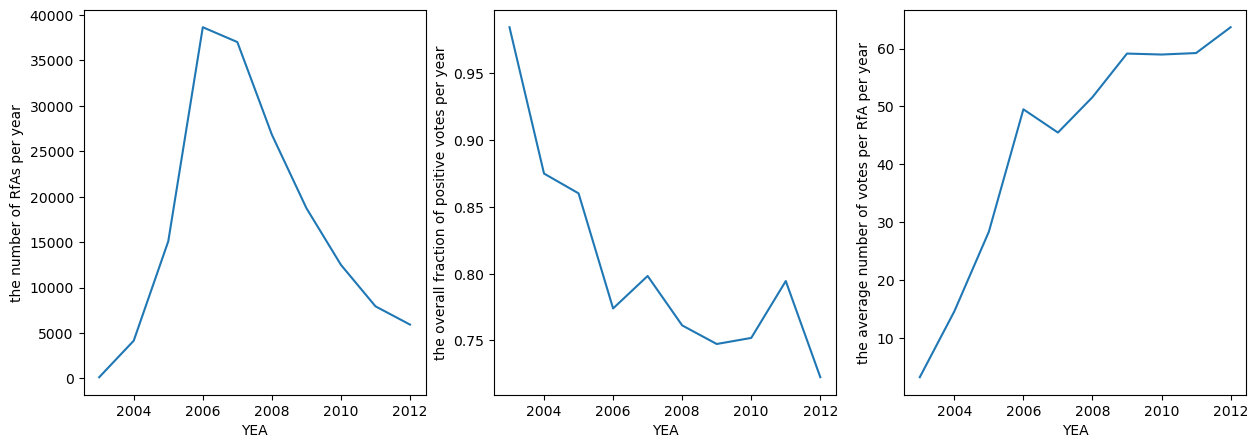

In [6]:
# 1.2 
f, axs = plt.subplots(1,3, sharex=True)
df.groupby('YEA')['TGT'].count().plot(ax=axs[0])
axs[0].set_ylabel('the number of RfAs per year')
df.groupby('YEA').apply(frac_pos).plot(ax=axs[1])
axs[1].set_ylabel('the overall fraction of positive votes per year')
df.groupby(['YEA','TGT']).count().groupby('YEA').mean()['SRC'].plot(ax=axs[2])
axs[2].set_ylabel('the average number of votes per RfA per year')
f.set_figheight(5)
f.set_figwidth(15)

In [7]:
df

,SRC,TGT,VOT,RES,YEA
0,5943,9966,-1,-1,2012
1,9153,9966,-1,-1,2012
2,4189,9966,-1,-1,2012
3,3750,9966,-1,-1,2012
4,4225,9966,-1,-1,2012
...,...,...,...,...,...
166998,3867,2762,1,1,2003
166999,8091,8486,1,1,2003
167000,1581,8767,1,1,2003
167001,1011,8056,1,1,2003


For year 2008

In [8]:
[df.groupby('YEA')['TGT'].count()[2008], 
 df.groupby('YEA').apply(frac_pos)[2008],
 df.groupby(['YEA','TGT']).count().groupby('YEA').mean()['SRC'][2008]]

[26833, 0.7612268475384787, 51.60192307692308]

**1.3** 
**/Discuss:/** Describe the temporal patterns observed in the plots you did in **T1.2**.

**A1.3** 
*YOUR ANSWER HERE*

Over time, adminship request increased till about 2008, before decrasing again. Also less and less positive votes. And much more votes per rfa than before.

In a nutshell seems that wikipedia is getting more strict with who can become an admin

**1.4** 
Create an undirected graph ([`nx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html)) where every node corresponds to a Wikipedia user (source or target of an RfA) and where there exists an edge between two users if at least one of them has voted on the other. Each edge should have attributes corresponding to columns of the dataframe, namely:
- `VOT`, which equals `1` if the vote was positive, and `-1` otherwise.
- `YEA`, an integer that represents the year of the RfA.

**The code to load the graph has been provided to you!** After running it, print the number of nodes and edges in your graph.

---

**Observation:** Note that we have at most one edge per pair of nodes in the graph, even though two votes may be associated with the pair  — e.g., if A voted in B's RfA in time $t_1$ and B voted in A's RfA in time $t_2$ ($t_1 < t_2$). In these cases, the code provided associates the metadata of the oldest vote ($t_1$ in the example) to the edge between A and B.

In [9]:
# Provided code! Do not change!
import networkx as nx
import pandas as pd
G = nx.from_pandas_edgelist(pd.read_csv("./wiki-RfA.csv"), 
                            'SRC', 'TGT', ['VOT', 'RES', 'YEA', 'DAT'], create_using=nx.Graph)

In [10]:
# 1.4
print(nx.info(G))


Graph with 10831 nodes and 161147 edges


/var/folders/rm/7_ymgfb97mbb78p4rhq92vww0000gn/T/ipykernel_5062/3669651718.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


**1.5** 
Plot the **complementary** cumulative distribution of the degree centrality of the undirected graph. Use a logarithmic (base 10) x-axis and a linear y-axis.

In [11]:
degrees = nx.degree_centrality(G)

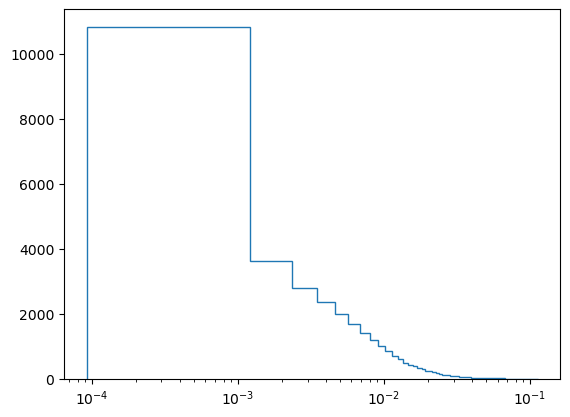

In [12]:
plt.hist(pd.Series(degrees),bins=100,cumulative=-1,histtype='step')
plt.xscale('log')


**1.6**
**/Discuss:/** Why is the following statement false? Justify your answer. **"From the graph obtained in task 1.5, one can conclude that around 40% of the users voted at least 11 times."**


**A1.6**
*YOUR ANSWER HERE*

We can see that a large number of users voted not very much (their degree centrality is low), but a very small number voted many many times, making the statement is false.

**1.7**
What fraction of users voted at least 11 times? Use the data to measure the fraction.

In [13]:
# 1.7

no_users = len(df.groupby('SRC').count())
more_than_11 = len(df.groupby('SRC').count()[df.groupby('SRC').count().TGT > 11])

print("This fraction of users voted more than 11 times: ", more_than_11/no_users)

This fraction of users voted more than 11 times:  0.26144590598552053


### Task 2: Triangles

Next, you set out to investigate the social balance theory by looking at the RfA graph.

**2.1**
Considering _only_ the RfAs of 2004 (i.e., where `YEA == 2004`), generate all triangles in the undirected graph.
Print the number of triangles found.
- **Hint:** Note that you can generate a graph with only a subset of nodes and edges via ` G.edge_subgraph`.
-  **Hint:** The function `nx.enumerate_all_cliques` generates all cliques in an undirected graph. First, all cliques of size 1 are generated, then all cliques of size 2, etc. Triangles are cliques of size 3.


In [14]:
edges_2004 = [(u,v) for u,v,e in G.edges(data=True) if e['YEA'] == 2004]
cliques = list(nx.enumerate_all_cliques(G.edge_subgraph(edges_2004)))
triangles = [clique for clique in cliques if len(clique)==3]
print('No triangles: ', len(triangles))

No triangles:  8448


**2.2 ** **/True or false:/** Is the following statement true or false? Justify your answer. **"The node with the highest clustering coefficient in an undirected graph is the node that belongs to the largest number of triangles."**

**A2.2**
*YOUR ANSWER HERE*

The clustering coefficient calculates the likelihood that two neighbors of a node are also connected to each other, it can be used to identify nodes that are in a densely connected neighborhood. Therefore the statement is **true**.

**2.3** Considering the set of triangles previously calculated, estimate the fraction of triangles of configurations
 $\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, and $\{+,-,-\}$. What fraction of triangles are "balanced" according to structural balance theory?

In [15]:
# 2.3
cnt = Counter()
configs = list()
for triangle in triangles:
    config = np.array([
        G[triangle[0]][triangle[1]]['VOT'],
        G[triangle[0]][triangle[2]]['VOT'],
        G[triangle[1]][triangle[2]]['VOT']]).sum()
    configs.append(config)

We can do a simplification - a triangle with config:

$\{+,+,+\}$,  will have the sum of the votes 3

$\{-,-,-\}$,  -3

$\{+,+,-\}$, 1

$\{+,-,-\}$. and -1

We therefore have the following number of configurations:

In [16]:
Counter(configs)

Counter({3: 6696, 1: 1178, -1: 530, -3: 44})

- structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$ as balanced,
  - and $\{+,+,-\}$, $\{-,-,-\}$ as unbalanced;

So the fraction that are balanced are:

In [17]:
(Counter(configs)[3]+Counter(configs)[-1]) / (Counter(configs)[3] + Counter(configs)[-1] + Counter(configs)[-3] + Counter(configs)[1])

0.8553503787878788

Which seems to validate the theory :) 

**2.4** To observe how triangle configurations would be distributed under a random null model, do the following:
- Create a new column `VOT_RND` in the dataframe, where RfA votes (i.e., edge signs in the graph) are shuffled, i.e., permuted randomly.  For shuffling, use `numpy.random`, without replacement and with the seed 32 (see code provided below).
- Create a new edge attribute with the values of `VOT_RND` in the graph you created in task **1.4**. You can do this easily using the  [`set_edge_attributes`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html) function.
- Considering the shuffled edge signs,  compute the fraction of triangles in each configuration ($\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, $\{+,-,-\}$). Moreover, compute the fraction of triangles that are "balanced" according to structural balance theory. (Reminder: consider only the RfAs of 2004.)


In [18]:
# PROVIDED STUB FOR 2.4
import numpy as np
np.random.seed(32)
df_2004 = df[df.YEA == 2004].copy(deep=True)
df_2004["VOT_RND"] = np.random.choice(df_2004["VOT"].values, size=len(df_2004), replace=False)

In [19]:
GG = nx.from_pandas_edgelist(df_2004, 
                            'SRC', 'TGT', ['VOT_RND'], create_using=nx.Graph)

In [20]:
# 2.4
cliques = list(nx.enumerate_all_cliques(GG))
triangles = [clique for clique in cliques if len(clique)==3]

cnt = Counter()
configs = list()
for triangle in triangles:
    config = np.array([
        GG[triangle[0]][triangle[1]]['VOT_RND'],
        GG[triangle[0]][triangle[2]]['VOT_RND'],
        GG[triangle[1]][triangle[2]]['VOT_RND']]).sum()
    configs.append(config)
Counter(configs)

Counter({1: 2348, -1: 291, 3: 5793, -3: 16})

In [21]:
(Counter(configs)[3]+Counter(configs)[-1]) / (Counter(configs)[3] + Counter(configs)[-1] + Counter(configs)[-3] + Counter(configs)[1])

0.7201704545454546

**2.5** **/Discuss:/** Do the results of tasks **2.3** and **2.4** suggest that structural balance theory is correct? What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) Justify your answer.

**A2.5** *YOUR ANSWER HERE*

The result of 2.3 showed that in real life 85% of the triangles were balanced, which seems good evidence of the theory. We can also see that in real life, in 2004 , the fraction of balanced nodes were higher than at random (85% vs 72% at random)

P values compute exactly the same thing, how extreme the observation is assuming the null hypothesis (random assignment) is true! So a statistical test could be done in the same fashion.

### Interlude: Additional data

In the data provided in the file `wiki-RfA.csv.gz` (with which you’ve worked up to now), each column corresponds to a vote from a user $u$ to a user $v$ at a time $t$. 

In **Task 2**, we did not consider the temporal aspect of this network. For the next task, you are provided with a complimentary dataset (`data/wiki-RfA_extra.csv.gz`) containing, for each vote (uniquely determined by `SRC` and `TGT`), a variety of features. **Importantly, these features were calculated considering only data that was already available at the time when the respective vote was cast.** The features are described as follows.

- `PP`, `NN`, `PN` — Each vote (signed edge) is part of zero or more triangles, and we computed the number of triangles in which the two remaining edges were both positive (`PP`), both negative (`NN`) and of different signs (i.e., one positive and one negative, `PN`). This considers only the votes the target (denoted by `TGT`) has received before the current vote. 

- `P`, `N` — The number of positive (`P`) and negative (`N`) votes that the target `TGT` received before the current vote.

- `TXT_PROCESSED` — The text in the original dataset, processed so 1) it is entirely lower-case, 2) it does not contain non-alphanumeric characters, and 3) it does not contain words starting with “supp” or “opp” (since words such as "support" and "oppose"  are obvious give-away signals of the vote).

### Interlude: Predicting edge signs with structural balance theory

We can use structural balance theory to predict edge signs. 

Consider an edge whose sign we do not know, as well as the fractions `PP`, `NN`, and `PN` associated with the edge, as defined above. 

According to structural balance theory, if `PP` + `NN` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

According to the weak structural balance theory, if `PP` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

Note that in both cases we use “$\geq$” rather than “<”, i.e., when both sides of the equation are equal, we break ties in favor of positive edges. We do so because there are more positive edges in the graph.

### Task 3: Predict it!

In the final part of the exam, you will leverage your machine learning and regression skills.

**3.1** Merge the new dataset with the original dataframe from task **1** using the columns `SRC` and `TGT`. You may drop the old `TXT` column if you want to. 


In [22]:
df

,SRC,TGT,VOT,RES,YEA
0,5943,9966,-1,-1,2012
1,9153,9966,-1,-1,2012
2,4189,9966,-1,-1,2012
3,3750,9966,-1,-1,2012
4,4225,9966,-1,-1,2012
...,...,...,...,...,...
166998,3867,2762,1,1,2003
166999,8091,8486,1,1,2003
167000,1581,8767,1,1,2003
167001,1011,8056,1,1,2003


In [23]:
# 3.1
df = df.merge(pd.read_csv("./wiki-RfA_extra.csv"),
         left_on=['SRC', 'TGT'],
         right_on=['SRC', 'TGT']
         ).drop(['YEA_y'], axis=1
                ).rename(columns={'YEA_x': 'YEA'})

In [24]:
df

,SRC,TGT,VOT,RES,YEA,PP,NN,PN,N,P,TXT_PROCESSED
0,5943,9966,-1,-1,2012,2,0,4,12,0,
1,9153,9966,-1,-1,2012,2,1,3,11,0,this joke really isn t funny not even if you ...
2,4189,9966,-1,-1,2012,0,0,2,10,0,as per nomination and answers
3,3750,9966,-1,-1,2012,0,0,0,9,0,and speeedy close this as wp snow as it s cle...
4,4225,9966,-1,-1,2012,0,0,1,8,0,per nomination and answers i am particularly ...
...,...,...,...,...,...,...,...,...,...,...,...
166998,3867,2762,1,1,2003,0,0,0,0,0,also llywrch has been here for ages and done n...
166999,8091,8486,1,1,2003,0,0,0,0,0,user talk fantasy thanks and other of his act...
167000,1581,8767,1,1,2003,0,0,0,0,0,for wikiquote but i haven t seen enough evide...
167001,1011,8056,1,1,2003,0,0,0,0,0,does good things with maps


**3.2**  Create the following two rule-based classifiers, and for each, estimate its area under the ROC curve (a.k.a. “AUC/ROC”) on the entire dataset:

- **A)** a classifier inspired by structural balance theory. The classifier should predict a positive vote if  `PP` + `NN` $\geq$ `PN`, and a negative vote otherwise.
- **B)** a classifier inspired by weak structural balance theory. The classifier should predict a positive vote if `PP`  $\geq$ `PN` and a negative vote otherwise.

In [25]:
# 3.2

df['RES_pred'] = (df.PP + df.NN >= df.PN).replace({True:1, False:-1})
df['RES_weak_pred'] = (df.PP >= df.PN).replace({True:1, False:-1})

df


,SRC,TGT,VOT,RES,YEA,PP,NN,PN,N,P,TXT_PROCESSED,RES_pred,RES_weak_pred
0,5943,9966,-1,-1,2012,2,0,4,12,0,,-1,-1
1,9153,9966,-1,-1,2012,2,1,3,11,0,this joke really isn t funny not even if you ...,1,-1
2,4189,9966,-1,-1,2012,0,0,2,10,0,as per nomination and answers,-1,-1
3,3750,9966,-1,-1,2012,0,0,0,9,0,and speeedy close this as wp snow as it s cle...,1,1
4,4225,9966,-1,-1,2012,0,0,1,8,0,per nomination and answers i am particularly ...,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166998,3867,2762,1,1,2003,0,0,0,0,0,also llywrch has been here for ages and done n...,1,1
166999,8091,8486,1,1,2003,0,0,0,0,0,user talk fantasy thanks and other of his act...,1,1
167000,1581,8767,1,1,2003,0,0,0,0,0,for wikiquote but i haven t seen enough evide...,1,1
167001,1011,8056,1,1,2003,0,0,0,0,0,does good things with maps,1,1


Distribution of votes:

In [26]:
[df.VOT.value_counts(),df.RES_pred.value_counts(), df.RES_weak_pred.value_counts()]

[ 1    130638
 -1     36365
 Name: VOT, dtype: int64,
  1    161917
 -1      5086
 Name: RES_pred, dtype: int64,
  1    161598
 -1      5405
 Name: RES_weak_pred, dtype: int64]

In [27]:
list(map(lambda y: roc_auc_score(df.VOT,y),[df.RES_pred, df.RES_weak_pred]))

[0.525390127858417, 0.528036104766419]

**3.3** To determine if the differences in the classifiers from task **3.2** occur solely due to chance, follow the following bootstrap procedure, using 200 iterations:

- **A)** Randomly sample the entire dataset (i.e., votes from the dataframe constructed in task **3.1**) with replacement;
- **B)** Compute the difference of the AUC/ROC for the two classifiers on the entire dataset.

Then use the distribution of AUC/ROC differences (one difference per bootstrap iteration) to estimate the 95% confidence interval for the AUC/ROC difference.

In [28]:
# 3.3 

**3.4 ** **/Discuss:**/ According to the results in tasks **3.2** and **3.3**, which theory better predicts actual edge signs, structural balance theory or the weak structural balance theory? 


**A3.4** *YOUR ANSWER HERE*

According to the results in 3.2, it seems that both theories' ROC AUC score is similar, therefore one cannot say that there is a winner.

**3.5** How accurately can we predict the vote with more sophisticated features and algorithms?

- Create a TF-IDF representation of the text of each vote  using `sklearn`'s vectorizer ([`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) with the parameters `max_features=150` and `stop_words='english'`.
- Split the  dataset into training and test sets using sklearn [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) using parameters `test_size=0.1` and  `random_state=42`.

- Then, train two logistic regression models ([`sklearn.linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)) using parameters `loss='log_loss'` and `max_iter=2000` considering:

    - **1)** the TF-IDF feature vector

    - **2)** the TF-IDF feature vector and the features `PP`, `NN`, `PN`, `P`, and `N` related to the graph.

- Last, report the AUC/ROC of each model in the test set.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df, df.VOT.replace({1:True,-1:False}), 
                                                    test_size=0.1, 
                                                    random_state=42)

In [30]:
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train.TXT_PROCESSED.values.astype('U'))

X_test_tf = vectorizer.transform(X_test.TXT_PROCESSED.values.astype('U'))

In [31]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., 'zzyzx', 'zzyzx11', 'zzz'], dtype=object)

In [35]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train_tf,y_train)
roc_auc_score(logistic.predict(X_test_tf),y_test)

/opt/homebrew/Caskroom/miniconda/base/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8830356966394168

**3.6** **/Discuss:**/  According to the results in task **3.5**, does information from the graph help in the task of predicting the vote even when using the text?  What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) 

**A3.6** *YOUR ANSWER HERE*

The ROC AUC is definitely higher

**3.7** Putting on your observational studies hat, run two logistic regressions using `statsmodels`.
- In the first regression, the vote is the outcome, and `PP`, `NN` and `PN` are the predictors.
- In the second regression, the vote is the outcome, and `PP`, `NN`, `PN`, and `N` are the predictors.

In [ ]:
# 3.7

**3.8** **/Discuss:**/   Explain what the coefficient associated with `PP` means in the first regression. Is it in accordance with structural balance theory?

**A3.8** *YOUR ANSWER HERE*

**3.9** **/Discuss:**/   Compare the coefficients associated with `PN` and `NN` in the first vs. the second regression. Present a reason that may explain this difference.

**A3.9**  *YOUR ANSWER HERE*

---